<a href="https://colab.research.google.com/github/tuancompa2610/Bankrupt-Poland-Predict/blob/main/Bankrupt_Poland_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries here
import gzip
import json
import pickle
from scipy.io import arff

import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import VimeoVideo
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: 1year.arff              
  inflating: 2year.arff              
  inflating: 3year.arff              
  inflating: 4year.arff              
  inflating: 5year.arff              


In [ ]:
# Loads the 5 raw .arff files into a list
def load_arff_raw_data():
    N=5
    return [arff.loadarff('/content/' + str(i+1) + 'year.arff') for i in range(N)]

############################################################
# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]

############################################################
# Set the column headers from X1 ... X64 and the class label as Y, for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('bankrupt')
    for df in dataframes:
        df.columns = cols

############################################################
# dataframes is the list of pandas dataframes for the 5 year datafiles.  
dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
set_new_headers(dataframes)    

# print the first 5 rows of a dataset 'year1'
df = pd.concat(dataframes)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,bankrupt
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [ ]:
# The class labels for all the dataframes are originally in object type.
# Convert them to int types
def convert_class_label_type_int(df):
    col = getattr(df, 'bankrupt')
    df['bankrupt'] = col.astype(int)
        
convert_class_label_type_int(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43405 entries, 0 to 5909
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        43397 non-null  float64
 1   X2        43397 non-null  float64
 2   X3        43397 non-null  float64
 3   X4        43271 non-null  float64
 4   X5        43316 non-null  float64
 5   X6        43397 non-null  float64
 6   X7        43397 non-null  float64
 7   X8        43311 non-null  float64
 8   X9        43396 non-null  float64
 9   X10       43397 non-null  float64
 10  X11       43361 non-null  float64
 11  X12       43271 non-null  float64
 12  X13       43278 non-null  float64
 13  X14       43397 non-null  float64
 14  X15       43369 non-null  float64
 15  X16       43310 non-null  float64
 16  X17       43311 non-null  float64
 17  X18       43397 non-null  float64
 18  X19       43277 non-null  float64
 19  X20       43278 non-null  float64
 20  X21       37551 non-null  flo

In [ ]:
def convert_columns_type_float(df):
    for i in range(1, df.shape[1] - 1):
        colname = df.columns[i]
        col = getattr(df, colname)
        df[colname] = col.astype(float)

convert_columns_type_float(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43405 entries, 0 to 5909
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        43397 non-null  float64
 1   X2        43397 non-null  float64
 2   X3        43397 non-null  float64
 3   X4        43271 non-null  float64
 4   X5        43316 non-null  float64
 5   X6        43397 non-null  float64
 6   X7        43397 non-null  float64
 7   X8        43311 non-null  float64
 8   X9        43396 non-null  float64
 9   X10       43397 non-null  float64
 10  X11       43361 non-null  float64
 11  X12       43271 non-null  float64
 12  X13       43278 non-null  float64
 13  X14       43397 non-null  float64
 14  X15       43369 non-null  float64
 15  X16       43310 non-null  float64
 16  X17       43311 non-null  float64
 17  X18       43397 non-null  float64
 18  X19       43277 non-null  float64
 19  X20       43278 non-null  float64
 20  X21       37551 non-null  flo

In [ ]:
df.shape[1]

65

<AxesSubplot:title={'center':'Class Balance'}, xlabel='Bankrupt', ylabel='Frequency'>

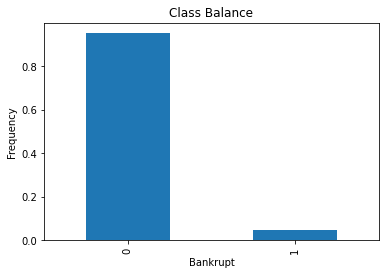

In [ ]:
# Plot class balance
df["bankrupt"].value_counts(normalize = True).plot(kind = "bar", xlabel = "Bankrupt", ylabel = "Frequency", title = "Class Balance")

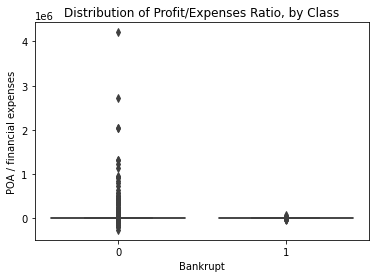

In [ ]:
# Create boxplot
sns.boxplot(x = df["bankrupt"], y = df["X27"])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

In [ ]:
df["X27"].describe()

count    4.064100e+04
mean     1.107896e+03
std      3.501237e+04
min     -2.590100e+05
25%      4.504800e-02
50%      1.084100e+00
75%      5.139300e+00
max      4.208800e+06
Name: X27, dtype: float64

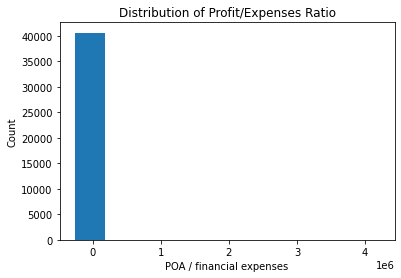

In [ ]:
# Plot histogram of `feat_27`
plt.hist(df["X27"])
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

In [ ]:
q1, q9 = df["X27"].quantile([0.1, 0.9])
mask = df["X27"].between(q1, q9)
mask.head()

0     True
1    False
2    False
3     True
4     True
Name: X27, dtype: bool

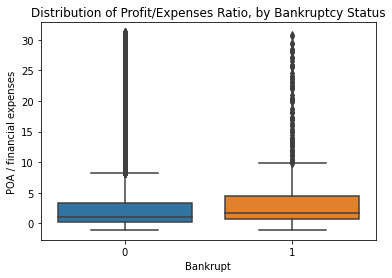

In [ ]:
# Create clipped boxplot
sns.boxplot(x = "bankrupt", y = "X27", data = df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

<AxesSubplot:>

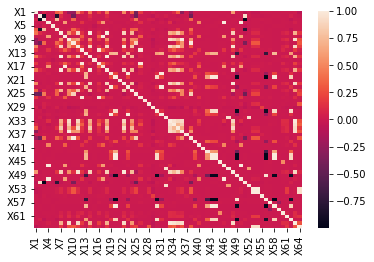

In [ ]:
corr = df.drop(columns = "bankrupt").corr()
sns.heatmap(corr)

### Data Split

In [ ]:
target = "bankrupt"
X = df.drop(columns = [target])
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (43405, 64)
y shape: (43405,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34724, 64)
y_train shape: (34724,)
X_test shape: (8681, 64)
y_test shape: (8681,)


In [ ]:
under_sampler = RandomUnderSampler(random_state = 42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(3300, 64)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,-0.196780,0.725500,0.18188,3.0821,25.056,0.0,-0.238160,0.37837,0.65133,0.27450,...,4016.60,-0.330730,-0.716850,-0.42584,2.0455,5.1974,6.0054,48.952,7.4563,0.8913
1,0.341250,0.110950,0.59612,6.7003,30.043,0.0,0.420400,8.01330,1.28400,0.88905,...,6654.70,0.331860,0.383830,0.67452,0.0000,2.4704,12.9360,29.729,12.2780,4.2898
2,0.011582,0.824950,0.09303,1.1902,-24.185,0.0,0.011582,0.21219,1.69320,0.17505,...,1161.30,0.018158,0.066162,0.99328,1.6749,8.9392,4.4818,105.440,3.4618,4.0523
3,0.547970,0.077456,0.66822,9.7478,464.280,0.0,0.678620,11.91000,1.34210,0.92254,...,796.30,0.597590,0.593980,0.50191,0.0000,NaN,11.0110,20.775,17.5690,5.2551
4,-0.022274,0.657270,0.29107,1.7282,17.059,0.0,-0.022274,0.52144,1.32110,0.34273,...,262.05,-0.803580,-0.064990,1.00940,0.0000,7.4160,5.4275,110.440,3.3050,4.2729


In [ ]:
over_sampler = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(66148, 64)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,-0.057539,0.44252,0.223210,1.57370,23.3010,0.161160,-0.055615,1.25980,0.94527,0.55748,...,8934.000,-0.057899,-0.10321,1.05790,0.095908,11.846,3.9378,101.98,3.5792,3.5914
1,-0.128080,0.85370,-0.025713,0.96909,-39.4380,-0.031407,-0.128080,0.17137,3.02940,0.14630,...,-1148.500,0.168690,-0.87547,0.85164,0.000000,14.730,5.2979,100.23,3.6416,15.6290
2,-0.104010,0.86107,0.059173,1.06870,1.8093,0.000000,-0.104010,0.16134,2.28140,0.13893,...,27.807,0.196490,-0.74866,0.80469,0.000000,45.658,2.6453,137.76,2.6495,28.6050
3,0.175230,0.76406,0.071079,1.09300,-26.2280,0.175230,0.212090,0.25730,1.05880,0.19660,...,679.300,0.055543,0.89134,0.94446,0.000000,10.222,3.4837,136.74,2.6693,12.3710
4,0.097003,0.69768,-0.129770,0.63575,-92.9040,0.116770,0.097003,0.42044,1.06030,0.29333,...,-3695.500,0.056866,0.33069,0.94313,1.163900,7.850,30.8920,100.27,3.6402,1.6766


# Model

In [ ]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9525


### Decision Tree

In [ ]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state = 42))
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state = 42))
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state = 42))
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [ ]:
for m in [model_reg, model_under, model_over]:
    acc_train = accuracy_score(y_train, m.predict(X_train))
    acc_test = accuracy_score(y_test, m.predict(X_test))

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9489
Training Accuracy: 0.8136
Test Accuracy: 0.8015
Training Accuracy: 1.0
Test Accuracy: 0.9543


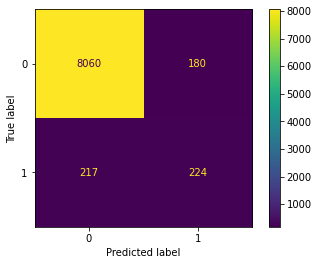

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test)

In [ ]:
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

43


Communicate

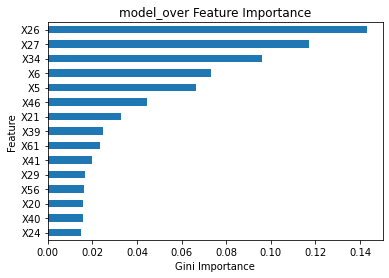

In [ ]:
# Get importances
features = X_train_over.columns
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index = features).sort_values()

# Plot series
feat_imp.tail(15).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

In [ ]:
# Save your model as `"model-5-2.pkl"`
with open("model-decision-tree.pkl", "wb") as f:
    pickle.dump(model_over, f)

In [ ]:
# Load `"model-5-2.pkl"`
with open("model-decision-tree.pkl", "rb") as f:
    loaded_model = pickle.load(f)
print(loaded_model)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])


### Random Forest

In [ ]:
clf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state = 42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [ ]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv = 5, n_jobs = -1)
print(cv_acc_scores)

[0.99818594 0.99780801 0.99697657 0.99848817 0.99712752]


In [ ]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [ ]:
model = GridSearchCV(
	clf,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.tail(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,26.673174,0.226129,0.242957,0.005134,30,50,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997732,0.997732,0.996825,0.997883,0.996901,0.997415,0.000455,4
15,27.361576,0.045773,0.243598,0.008488,30,50,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997581,0.997506,0.996825,0.997959,0.995994,0.997173,0.000694,8
16,39.779727,0.396018,0.336831,0.022878,30,75,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997657,0.997581,0.996750,0.998035,0.996825,0.997370,0.000500,6
17,40.799881,0.810948,0.527931,0.202261,30,75,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997732,0.997506,0.996901,0.997657,0.996372,0.997233,0.000521,7
18,13.603352,0.774346,0.200051,0.064482,40,25,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.997581,0.996825,0.996447,0.998261,0.996447,0.997113,0.000708,9
19,14.370835,0.142813,0.188811,0.060341,40,25,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.997506,0.997279,0.996674,0.997657,0.995994,0.997022,0.000613,10
20,26.342705,0.324542,0.289343,0.105404,40,50,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.998035,0.997732,0.997052,0.998564,0.997052,0.997687,0.000583,1
21,27.525882,0.271263,0.308452,0.147595,40,50,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.998035,0.997732,0.997128,0.997959,0.996069,0.997385,0.000731,5
22,39.846238,0.195446,0.342749,0.013762,40,75,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.997884,0.997581,0.997128,0.998337,0.997052,0.997596,0.000479,2
23,40.480815,1.940122,0.342123,0.038023,40,75,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.998186,0.997808,0.997052,0.998110,0.996145,0.997460,0.000770,3


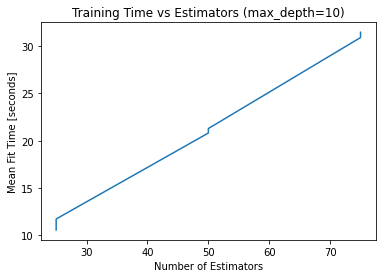

In [ ]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
	cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

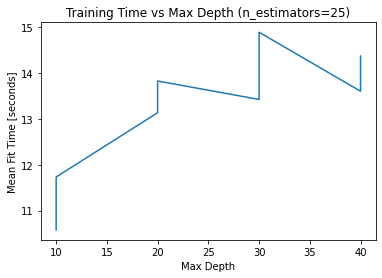

In [ ]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
# Plot fit time vs max_depth
plt.plot(
	cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

In [ ]:
# Extract best hyperparameters
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=50,
                                        random_state=42))])

In [ ]:
model = make_pipeline(SimpleImputer(strategy = "median"), RandomForestClassifier(max_depth = 40, n_estimators = 50, random_state = 42))
model.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=50,
                                        random_state=42))])

In [ ]:
acc_train = accuracy_score(y_train_over, model.predict(X_train_over))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9627


In [ ]:
y_test.value_counts()

0    8240
1     441
Name: bankrupt, dtype: int64

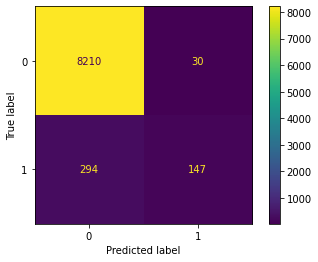

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

Communicate

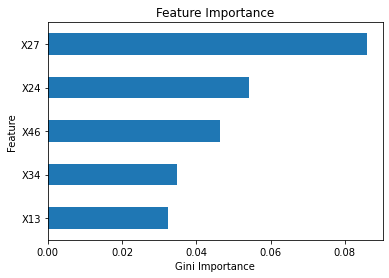

In [ ]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values()
# Plot 10 most important features
feat_imp.tail().plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [ ]:
# Save model
with open("model-random-forest.pkl", "wb") as f:
    pickle.dump(model, f)

# Gradient Boosting

In [ ]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier(random_state = 42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])


In [ ]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__max_depth": range(2, 5),
    "gradientboostingclassifier__n_estimators": range(20, 31, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__max_depth': range(2, 5),
 'gradientboostingclassifier__n_estimators': range(20, 31, 5)}

In [ ]:
model = GridSearchCV(
	clf,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# Fit model to over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,65.457159,1.024469,0.043180,0.016223,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.874981,0.879667,0.876644,0.870965,0.874820,0.875416,0.002826,1
16,66.376083,0.920975,0.036195,0.000705,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.870975,0.874906,0.877400,0.870512,0.869605,0.872679,0.002976,2
15,55.149150,0.270137,0.035164,0.001261,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.867725,0.872940,0.871353,0.862726,0.867035,0.868356,0.003573,3
14,54.839669,0.264078,0.048416,0.017482,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.866667,0.867498,0.865835,0.864389,0.861063,0.865090,0.002261,4
13,44.893038,0.964222,0.046695,0.017692,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.859335,0.865306,0.863114,0.853730,0.860760,0.860449,0.003929,5
12,43.663427,0.882518,0.034018,0.003306,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.857974,0.862132,0.857823,0.858039,0.851765,0.857547,0.003315,6
10,51.359030,0.756394,0.041844,0.013721,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.840212,0.845427,0.839909,0.842014,0.836722,0.840857,0.002851,7
11,54.519236,4.816720,0.035453,0.001763,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.837793,0.837944,0.838322,0.837176,0.830146,0.836276,0.003087,8
8,42.599621,0.526343,0.048356,0.016842,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.832729,0.837642,0.830990,0.837251,0.831355,0.833993,0.002881,9
9,42.694944,0.128646,0.033341,0.001250,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.829327,0.836432,0.831822,0.830221,0.823569,0.830274,0.004151,10


In [ ]:
# Extract best hyperparameters
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, n_estimators=30,
                                            random_state=42))])

In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8685
Validation Accuracy: 0.8615


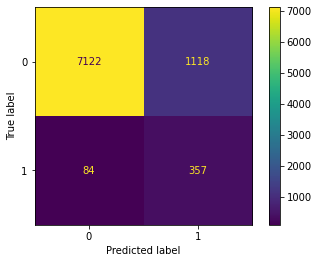

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)